```sql
SET receive_timeout = 1200;
SET send_timeout = 1200;
SET connect_timeout = 1200;
SET idle_connection_timeout = 1200;
WITH
    profiles AS (
        SELECT _id, account_id, profile_is_child
        FROM remote(
            '*************************',
            dict_source,
            profiles_table,
            '*********',
            '*******'
        ) AS profiles
        LIMIT 400000
    ),
    accounts AS (
        SELECT DISTINCT
            _id, geo
        FROM remote(
            '*************************',
            dict_source,
            users_table,
            '*********',
            '*******'
        ) AS accounts
        WHERE notEmpty(accounts.geo)
    ),
    vitrina AS (
        SELECT id, genres, hashtags, cls, title
        FROM remote(
            '*************************',
            vitrina,
            vitrina_product_dict,
            '*********',
            '*******'
        ) AS vitrina
    )
SELECT
    profiles._id AS profile_id,
    any(profiles.profile_is_child) AS profile_is_child,
    any(accounts.geo) AS geo,
    groupArray(products.product_id) AS product_ids,
    groupArray(products.device_family) AS device,
    arraySum(groupArray(products.delta)) AS delta,
    arraySum(groupArray(products.positive)) AS positive,
    arraySum(groupArray(products.negative)) AS negative,
    arrayFlatten(groupArray(vitrina.genres)) AS genres,
    arrayFlatten(groupArray(vitrina.hashtags)) AS hashtags,
    groupArray(vitrina.title) AS titles,
    groupArray(vitrina.cls) AS cls,
    groupArray(toString(products.start)) AS starts,
    groupArray(toString(products.progress)) as progress,
    groupArray(toString(products.version)) AS versions
FROM remote(
    '*************************',
    stream,
    playback_sum_product_table,
    '*********',
    '*******'
) AS products
JOIN profiles ON toString(products.profile_id) = profiles._id
JOIN accounts ON toString(accounts._id) = profiles.account_id
JOIN vitrina ON vitrina.id = products.product_id
GROUP BY profile_id
LIMIT 400000

In [1]:
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ast
import category_encoders as ce
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from gower import gower_matrix
from utils import multiple_graphs
from prince import MCA, PCA
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.compose import ColumnTransformer

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="using precomputed metric; inverse_transform will be unavailable")

In [3]:
df = pd.read_csv('Result_13_5.csv').drop('titles', axis=1)
print(df.shape)

(8344, 14)


## Предварительная обработка датасета

In [4]:
# Делаем преобразования некоторых полей, с помощью библиотеки ast после импорта из csv
for col in df.drop(['profile_id', 'geo'], axis=1).select_dtypes(include='object').columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])  
df.head()

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions
0,de4599ae-01a2-46b5-8e23-49b47e0a1627,0,RU,"[608da742-46c3-4a5d-8134-532fd391a456, fb688a1...","[tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, t...",570663147,0,0,"[detective, drama, thriller, drama, criminal, ...","[Ведется расследование, Мрачная атмосфера, Тай...","[Series, Series, Series, Movie, Series, Series...","[2023-07-09 08:12:19, 2023-10-16 20:52:39, 202...","[0.116739236, 0.21479225, 0.8048347, 0.0646012...","[2023-07-09 08:56:19, 2023-10-16 22:03:39, 202..."
1,bbbb3da4-f035-4eea-8f1f-30c954cc2ff9,0,RU,"[a3e1ac99-0641-4e28-906f-6b0e23835071, df54ef6...","[mobile, mobile, mobile, mobile]",28075000,0,0,"[thriller, horror, horror, mystic, drama, horr...","[Поколение социальных сетей, Фильмы на Хэллоуи...","[Movie, Movie, Series, Movie]","[2023-12-09 14:34:26, 2023-12-03 13:54:05, 202...","[0.86251444, 0.8919203, 0.69836575, 0.03018878]","[2023-12-09 14:36:26, 2023-12-03 13:58:02, 202..."
2,36183683-d0c0-4fcd-9890-4ef6cb6b2489,0,US,"[608da742-46c3-4a5d-8134-532fd391a456, 1987184...","[mobile, web, web, web, web, web, web, web, we...",424415879,0,0,"[detective, drama, comedy, scifi, comedy, dram...","[Ведется расследование, Мрачная атмосфера, Тай...","[Series, Series, Movie, Movie, Series, Movie, ...","[2023-07-19 05:14:22, 2023-10-22 05:53:51, 202...","[0.117806844, 0.12354234, 0.11813199, 0.258489...","[2023-07-19 05:14:22, 2023-10-22 06:40:25, 202..."
3,630f1f10-381b-409f-bca3-489fe645999e,0,CA,"[49b1a1f6-a4bb-4a6c-adcc-fde2c0cbd0c4, 112116a...","[tv, tv, tv, tv]",98034,0,0,"[drama, scifi, comedy, thriller, drama, detect...","[Лето, солнце, любовь, Фильмы и сериалы для от...","[Movie, Series, Series, Series]","[2023-09-14 08:17:20, 2023-07-29 04:48:00, 202...","[0.003368983, 0.00021035213, 0.000009444594, 0...","[2023-09-14 08:17:21, 2023-07-29 04:48:21, 202..."
4,e48601ac-6ea1-4f82-b8fe-df6537fc3b21,0,GB,"[5de35919-f8a6-40e3-95a3-cbf90358d4c5, 7262fe6...","[tv, tv, tv, tv]",6849535,0,0,"[comedy, detective, adventure, comedy, family,...","[Герои с харизмой, Служебный роман, Истории с ...","[Series, Series, Movie, Series]","[2024-01-05 11:25:23, 2023-07-10 15:49:46, 202...","[0.124134436, 0.00097538676, 0.0010978448, 0.0...","[2024-01-05 11:25:23, 2023-07-10 18:46:43, 202..."


In [5]:
# Определяем самые часто встречающиеся значения в колонках device, genres, hashtags, cls, если таких значений больше одного
# то заменяем их значением "various". Это позволит избежать большого разброса данных.
def most_frequent(row):        
    counts = Counter(row)
    data = [i for i, v in zip(counts.keys(), counts.values()) if v == max(counts.values())]
    if len(data) > 1:
        return 'various'
    return ''.join(data)
for col in ['device', 'genres', 'hashtags', 'cls']:
    df[col] = df[col].apply(most_frequent)
    
# Обрабатываем временные данные. Преобразуем время начала просмотра в колонке "starts" в категории утро, день, вечер, ночь
# и определим самые часто встречающиеся значения. Это также позволит избежать большого разброса данных.

def time_of_day(h):
    if 5 <= h < 11: return 'Morning'
    elif 11 <= h < 17: return 'Day'
    elif 17 <= h < 23: return 'Evening'
    else: return 'Night'

# Делаем категориальный признак - наиболее частое количество просмотров утром, днем вечером или ночью 
df['period'] =  df['starts'].apply(
    lambda times: [time_of_day(pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').hour) for t in times if t]
).apply(most_frequent)

# Сделаем еще один категориальный признак наиболее часто встречающиеся просмотры по дням недели (будни / выходные)
df['weekdays'] = df['starts'].apply(
    lambda times: [
        'weekend' if pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').weekday() in [5, 6] else 'weekdays'
        for t in times if t
    ]
).apply(most_frequent)

# Сделаем числовой признак - количество просмотров
df['views_count'] = df['product_ids'].apply(lambda x: len(x))
df['progress'] = df['progress'].map(lambda x: list(pd.to_numeric(x, errors='coerce')))

# Сделаем числовой признак - средний прогресс по просмотрам продуктов
df['mean_progress'] = df['progress'].apply(np.mean)

# Разделение признаков на числовые и категориальные
num_cols = df.drop('profile_is_child', axis=1).select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.drop(list(num_cols)+['profile_id', 'product_ids', 'starts', 'versions', 'progress'], axis=1).columns
df.head(10)

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions,period,weekdays,views_count,mean_progress
0,de4599ae-01a2-46b5-8e23-49b47e0a1627,0,RU,"[608da742-46c3-4a5d-8134-532fd391a456, fb688a1...",tv,570663147,0,0,drama,С субтитрами для слабослышащих,Series,"[2023-07-09 08:12:19, 2023-10-16 20:52:39, 202...","[0.116739236, 0.21479225, 0.8048347, 0.0646012...","[2023-07-09 08:56:19, 2023-10-16 22:03:39, 202...",Day,weekdays,24,0.822477
1,bbbb3da4-f035-4eea-8f1f-30c954cc2ff9,0,RU,"[a3e1ac99-0641-4e28-906f-6b0e23835071, df54ef6...",mobile,28075000,0,0,horror,Фильмы на Хэллоуин,Movie,"[2023-12-09 14:34:26, 2023-12-03 13:54:05, 202...","[0.86251444, 0.8919203, 0.69836575, 0.03018878]","[2023-12-09 14:36:26, 2023-12-03 13:58:02, 202...",Day,weekend,4,0.620747
2,36183683-d0c0-4fcd-9890-4ef6cb6b2489,0,US,"[608da742-46c3-4a5d-8134-532fd391a456, 1987184...",web,424415879,0,0,drama,С субтитрами для слабослышащих,Series,"[2023-07-19 05:14:22, 2023-10-22 05:53:51, 202...","[0.117806844, 0.12354234, 0.11813199, 0.258489...","[2023-07-19 05:14:22, 2023-10-22 06:40:25, 202...",Night,weekdays,60,0.482349
3,630f1f10-381b-409f-bca3-489fe645999e,0,CA,"[49b1a1f6-a4bb-4a6c-adcc-fde2c0cbd0c4, 112116a...",tv,98034,0,0,drama,various,Series,"[2023-09-14 08:17:20, 2023-07-29 04:48:00, 202...","[0.003368983, 0.00021035213, 9.444594e-06, 0.0...","[2023-09-14 08:17:21, 2023-07-29 04:48:21, 202...",Morning,weekdays,4,0.001399
4,e48601ac-6ea1-4f82-b8fe-df6537fc3b21,0,GB,"[5de35919-f8a6-40e3-95a3-cbf90358d4c5, 7262fe6...",tv,6849535,0,0,comedy,various,Series,"[2024-01-05 11:25:23, 2023-07-10 15:49:46, 202...","[0.124134436, 0.00097538676, 0.0010978448, 0.0...","[2024-01-05 11:25:23, 2023-07-10 18:46:43, 202...",Day,weekdays,4,0.048666
5,962faf0a-4fff-48cf-81fb-af9dfba8f826,0,RU,"[bef83a46-4f8c-45f4-92fc-071e577f230a, 999878e...",tv,51200568,23,4,comedy,various,Series,"[2023-12-07 14:59:39, 2023-12-02 15:21:40, 202...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015412219, 0....","[2023-12-07 14:59:39, 2023-12-02 15:30:40, 202...",Day,weekend,12,0.205459
6,7cb57578-284e-43b1-b0c3-468e1b0ec998,0,GB,"[55b61165-1d6d-4216-80f8-95ffda3bd528, 5de3591...",tv,5753571,0,0,comedy,various,various,"[2024-02-13 18:54:18, 2024-02-09 00:09:20, 202...","[6.5616456e-05, 0.00018667008, 1.1093224, 0.51...","[2024-02-13 18:54:18, 2024-02-09 00:09:25, 202...",various,weekdays,8,0.211594
7,c2e6d4a4-f187-429e-a271-a776a3ed39d4,0,RU,"[55b61165-1d6d-4216-80f8-95ffda3bd528, d8876cb...",mobile,292577934,0,0,comedy,various,Series,"[2024-02-18 08:46:27, 2024-04-09 20:36:54, 202...","[0.5755891, 0.0005910214, 2.85789, 1.0272274, ...","[2024-02-18 09:28:11, 2024-04-09 20:37:07, 202...",Day,weekdays,19,0.708394
8,9a8978d0-c266-41dc-9b39-18e85d6213d6,0,RU,"[d8876cba-10a9-4f0e-8531-8ab0772427e3, 06651d3...",web,201512833,0,0,various,С субтитрами для слабослышащих,Series,"[2024-04-12 13:02:40, 2024-06-05 05:46:55, 202...","[0.0002157151, 0.4659425, 0.49857622, 0.096257...","[2024-04-12 13:02:40, 2024-06-05 07:17:26, 202...",Evening,weekdays,22,0.308554
9,a1c5489e-bb23-47d2-8f2e-3f2903a9b45a,0,RU,"[d7b56f51-a17f-4bcb-8736-fc3375d38dd4, 4b5d381...",tv,1499049920,0,0,drama,Турецкие сериалы,Series,"[2024-05-28 15:44:55, 2024-06-27 17:09:50, 202...","[0.0022975197, 0.049814027, 0.03405041, 0.0994...","[2024-05-28 15:44:55, 2024-06-27 17:09:50, 202...",Day,weekdays,28,0.369070


## Анализ датасета
### Числовые признаки

In [6]:
def bar_box_plot(data: pd.DataFrame):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    sns.barplot(data=data, ax=ax1)
    ax1.set_title('Средние значения признаков')
    sns.boxplot(x='Features', y='Values', data=data.melt(var_name='Features', value_name='Values'), ax=ax2)
    ax2.set_title('Распределение признаков')
    plt.show()

Проверяем числовые признаки на корреляцию, строим тепловую карту

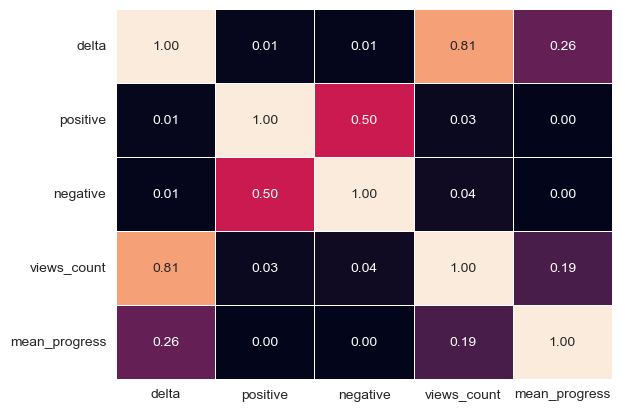

In [7]:
sns.heatmap(df[num_cols].corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

Видим, что views_count(число просмотров) и delta(общая длительность просмотров) сильно скоррелированы, поэтому один признак можно убрать. Убираю delta (общая длительность просмотров в секундах).

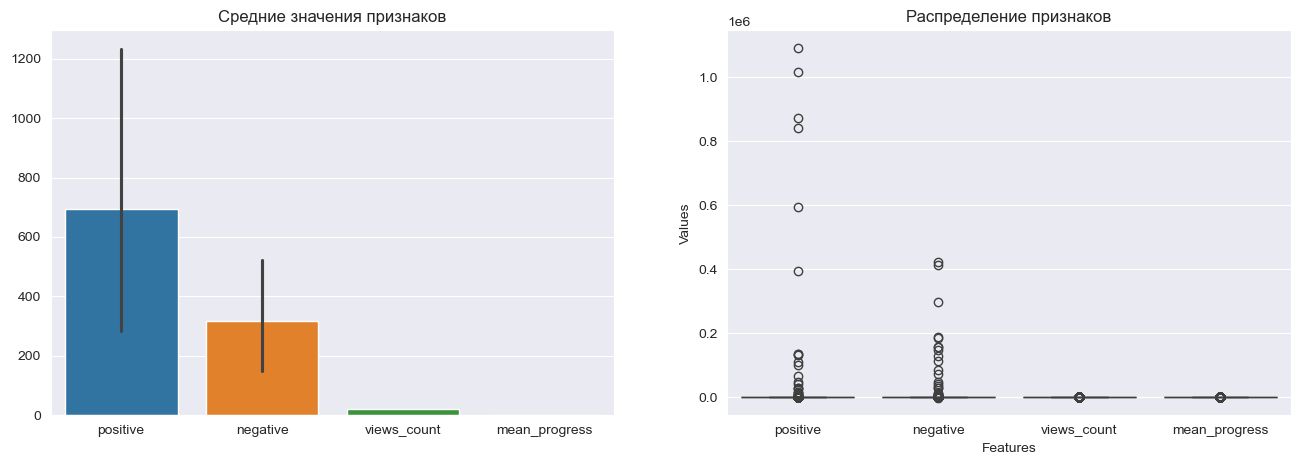

In [8]:
num_cols = num_cols.drop(['delta'])
bar_box_plot(df[num_cols])

Наблюдаем очень большой разброс и большое количество выбросов в числовых признаках. Необходимо сделать нормализацию числовых данных. Стандартизация для k-prototypes не подходит, т.к. Z-score создает отрицательные значения, что усложняет интерпретацию центроидов и может давать артефакты при расчете расстояний

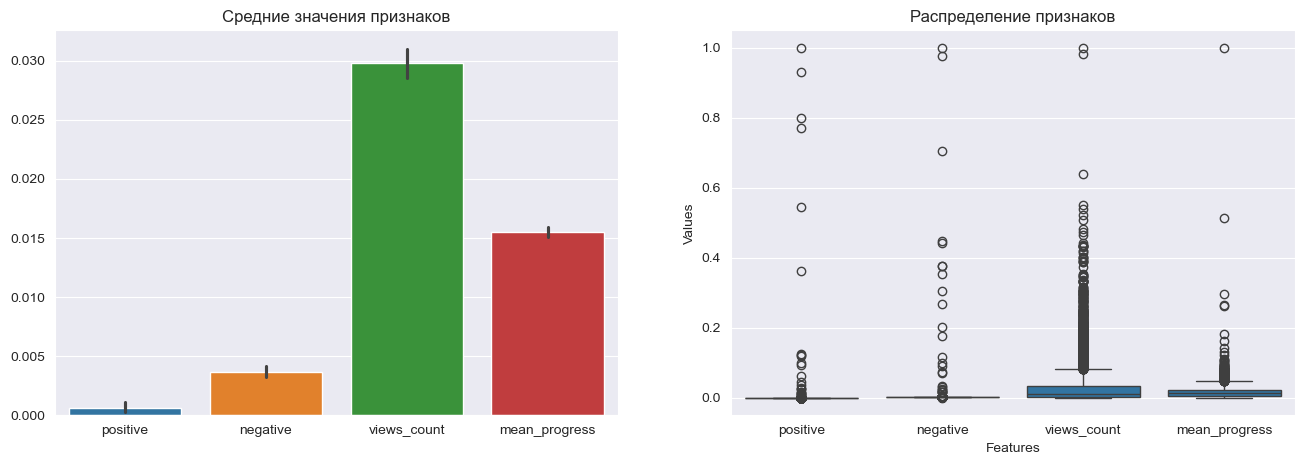

In [9]:
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
bar_box_plot(df[num_cols])

### Категориальные признаки

In [10]:
df[cat_cols].head()

,profile_is_child,geo,device,genres,hashtags,cls,period,weekdays
0,0,RU,tv,drama,С субтитрами для слабослышащих,Series,Day,weekdays
1,0,RU,mobile,horror,Фильмы на Хэллоуин,Movie,Day,weekend
2,0,US,web,drama,С субтитрами для слабослышащих,Series,Night,weekdays
3,0,CA,tv,drama,various,Series,Morning,weekdays
4,0,GB,tv,comedy,various,Series,Day,weekdays


Смотрим количество уникальных значений в каждой колонке

In [11]:
df[cat_cols].nunique()

profile_is_child     2
geo                 62
device               4
genres              22
hashtags            98
cls                  3
period               5
weekdays             3
dtype: int64

Удаляем самые большие значения - geo и hashtags, так как большое количество категориальных признаков может привести к проблемам с выбором центроидов, переобучению и сложности в интерпретации кластеров


In [12]:
cat_cols = cat_cols.drop(['geo', 'hashtags'])

Построим график распределения кластеров

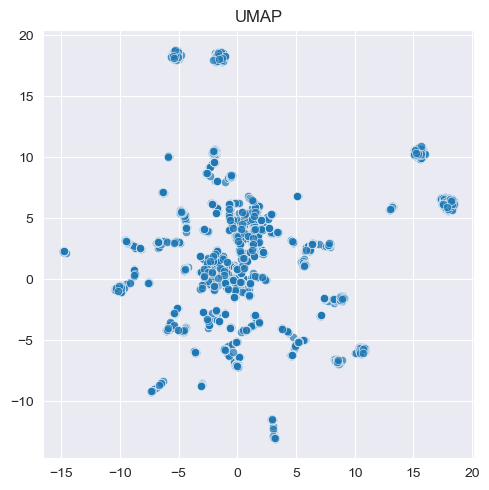

In [13]:
def draw_clusters(dataframe: pd.DataFrame):
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(dataframe)
    reducer = umap.UMAP()
    _emb = reducer.fit_transform(encoded)
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=_emb[:, 0],
        y=_emb[:, 1],
        alpha=0.7
    )
    plt.title('UMAP')
    plt.tight_layout()
    plt.show()
draw_clusters(df[cat_cols])

Видно что кое-где образовываются кластеры, но в основном картина не очень

## Обучение K-modes

K-modes - это неконтролируемый метод машинного обучения, используемый для группировки набора объектов данных в указанное количество кластеров на основе их категориальных атрибутов. Он использует моды (наиболее частые значения) вместо средних значений или медиан для представления кластеров.
Для измерения сходства и различия используются для определения расстояния между объектами данных в наборе данных. В случае K-modes эти расстояния вычисляются с использованием меры различия, называемой расстоянием Хэмминга, в отличие от более известного алгоритма k-means, который кластеры складывает численные данные, основанные на евклидовом расстоянии. <br>

Расстояние Хэмминга или мера несовпадения (Simple Matching Dissimilarity):


$$ d(x_i, c_j) =  \sum_{m = 1}^{p}\sigma(x_{i,m}, c_{i,m})$$ где: $p$ - количество признаков, <br> $\sigma(a, b) = \begin{cases} 0, & \text{ если } a = b \\ 1,  & \text{ если } a \neq b \end{cases}$

Пример: <br>
Пусть $x_i = [Красный,Большой]$, $c_j = [Синий,Большой]$.<br>
Тогда $ d(x_i, c_j) = 1 + 0 = 1 $

В алгоритме используются следующие шаги: <br>
1. Выбираются $k$ случайных объектов из датасета в качестве начальных мод. <br>
2. Каждый объект $x_i$ приписывается к кластеру с ближайшей модой
3. Для каждого кластера $j$ вычисляется новая мода $c_j$ — категориальное значение, которое чаще всего встречается в кластере по каждому признаку. <br>
4. Если моды не изменились или достигнуто максимальное число итераций → остановка. Иначе повторяются шаги 2 и 3.


Обучим модель k-modes "из коробки" на 8-ми кластерах и посчитаем метрики. <br>
Возьмем следующие метрики: <br>
Силуэтный коэффициент (Silhouette Score): Этот коэффициент измеряет, насколько объект похож на свой кластер по сравнению с соседними кластерами. Значение от +1 до -1, где 1 подразумевает, что объект правильно классифицирован, 0 указывает на сопредельные кластеры, а -1 означает, что он был неправильно отнесен к кластеру. Силуэтный коэффициент полезен для оценки и сравнения различных кластеризаций. <br>
Коэффициент Калински-Харабаза (Calinski-Harabasz Index): Этот индекс измеряет соотношение между внутрикластерной дисперсией и межклассовой дисперсией. Более высокие значения этого индекса указывают на более качественные кластеризации. <br>
Индекс Дэвиса-Боулдина (Davies-Bouldin Index): Он измеряет среднее отношение между внутрикластерными расстояниями и межкластерными расстояниями. Более низкие значения индекса указывают на лучшее качество кластеризации.

In [14]:
# Делаем функцию для подсчета метрик, в которой используем матрицу Говера. Матрица Говера - это мера сходства между объектами
# (или строками) в данных, которая учитывает не только числовые, но и категориальные переменные. Она позволяет вычислить матрицы 
# расстояний между объектами с использованием различных типов данных.

def scores_calc(dataframe, clrs, metric):
    gm = gower_matrix(dataframe)
    shi = silhouette_score(gm, clrs, metric=metric)
    chi = calinski_harabasz_score(gm, clrs)
    dbi = davies_bouldin_score(gm, clrs)
    return shi, chi, dbi

# Так как очень большой датасет, для экономии времени делаем выборку
num_rows = 1000
X = df[cat_cols].head(num_rows)

# Делаем KModes из коробки
km = KModes(n_jobs=-1)
clusters = km.fit_predict(X)
scores = scores_calc(X, clusters, 'hamming')
print(f"Silhouette Score: {scores[0]} \nCalinski-Harabasz Score: {scores[1]}\nDavies-Bouldin Score: {scores[2]}")

Silhouette Score: 0.05724230169352873 
Calinski-Harabasz Score: 67.23709732336292
Davies-Bouldin Score: 2.0461613856648047


Все метрики плохие, в частности очень низкий показатель Silhouette Score, нормальные результаты начинаются когда s_score > 0.5, а хорошие при s_score > 0.7.
Попробуем найти самые важные признаки и убрать менее значимые. 
Для этого используем библиотеку prince https://maxhalford.github.io/prince/ и класс MCA, работающий с категориальными признаками

In [15]:
cat_data = df[cat_cols]
mca = MCA(n_iter=10, random_state=42, engine='sklearn')

mca = mca.fit(cat_data)
modality_contributions = mca.column_contributions_
explained_inertia = mca.eigenvalues_
dummy_to_feat = [col.split('_')[0] for col in modality_contributions.index]
feat_importance = {}
for feat in set(dummy_to_feat):
    idx = [i for i,f in enumerate(dummy_to_feat) if f == feat]
    m = modality_contributions.iloc[idx,:].values
    imp = np.sum(np.abs(m) * explained_inertia, axis=1).sum()
    feat_importance[feat] = imp
feat_importance = pd.Series(feat_importance).sort_values(ascending=False)
print(feat_importance)

genres      0.142504
profile     0.119061
period      0.075859
weekdays    0.075798
cls         0.052205
device      0.052201
dtype: float64


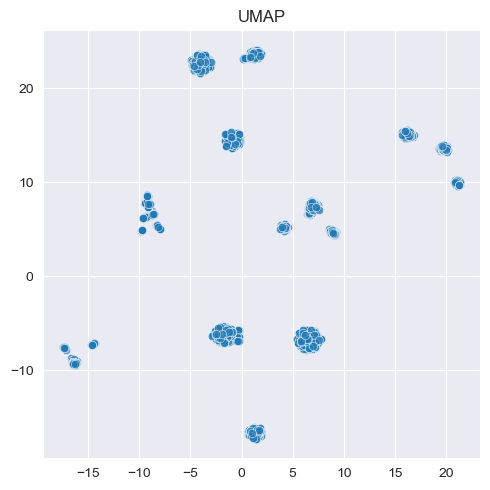

In [16]:
final_cat_cols = cat_cols.drop(feat_importance[-3:].index.tolist())
draw_clusters(df[final_cat_cols])

Видим на визуализации уже вполне отчетливые кластеры. Проведем повторную оценку кластеров

In [17]:
X = df[final_cat_cols].head(num_rows)
km = KModes(n_jobs=-1)
clusters = km.fit_predict(X)
scores = scores_calc(X, clusters, 'hamming')
print(f"Silhouette Score: {scores[0]} \nCalinski-Harabasz Score: {scores[1]}\nDavies-Bouldin Score: {scores[2]}")

Silhouette Score: 0.5594445350956727 
Calinski-Harabasz Score: 379.1155152997389
Davies-Bouldin Score: 0.8201655658940395


Видим, что Silhouette Score стал выше.
Сделаем оптимизацию гиперпараметра n_clusters

Сделаем оптимизацию с помощью библиотеки hyperopt, определим минимальное количество кластеров.
В качестве параметров оптимизации возьмем количество кластеров n_clusters и метод инициализации init. <br>
Коротко о методах иницилизации Huang и Cao:<br>

#### Huang (1997) - cтандартный метод инициализации.
Первая мода выбирается случайно из датасета.
Последующие моды выбираются с вероятностью, пропорциональной расстоянию до ближайшей существующей моды.
Использует категориальное расстояние (меру несовпадения).

#### Метод Cao (2009) - улучшенная инициализация, учитывающая плотность распределения данных.
Вычисляет "плотность" для каждого объекта (на основе частоты его категориальных значений).
Первая мода выбирается как объект с наибольшей плотностью.
Последующие моды выбираются с учетом плотности и расстояния до существующих мод.


In [18]:
def objective_modes(params):
    n_clrs = int(params['n_clusters'])
    init = params['init']
    model = KModes(n_clusters=n_clrs, init=init, n_init=4, random_state=42, n_jobs=-1)
    clrs = model.fit_predict(X)
    cost = model.cost_
    # штраф за большое количество кластеров
    penalty = 0.3 * n_clrs
    
    ss, chs, dbi = scores_calc(X, clrs, 'hamming')
    return {
        'loss': -ss + cost + dbi - chs + penalty,
        'status': 'ok', 
        'n_clusters': n_clrs, 
        'cost': cost, 
        'silhouette': ss,
        'calinski_harabasz': chs,
        'davies_bouldin' :dbi,
        'init': init
    }
space = {
    'n_clusters': hp.choice('n_clusters', range(2, 40)),
    'init': hp.choice('init', ['Huang', 'Cao']),
}

trials = Trials()
fmin(fn=objective_modes, space=space, algo=tpe.suggest, max_evals=40, trials=trials)
print(f"Лучшие гиперпараметры:\n{trials.best_trial['result']}")
n_kmodes = trials.best_trial['result']['n_clusters']
i_kmodes = trials.best_trial['result']['init']

100%|██████████| 40/40 [00:26<00:00,  1.52trial/s, best loss: -1698.9373608036933]
Лучшие гиперпараметры:
{'loss': -1698.9373608036933, 'status': 'ok', 'n_clusters': 39, 'cost': 20.0, 'silhouette': 0.9243345368707804, 'calinski_harabasz': 1730.614587533434, 'davies_bouldin': 0.9015612666113364, 'init': 'Huang'}


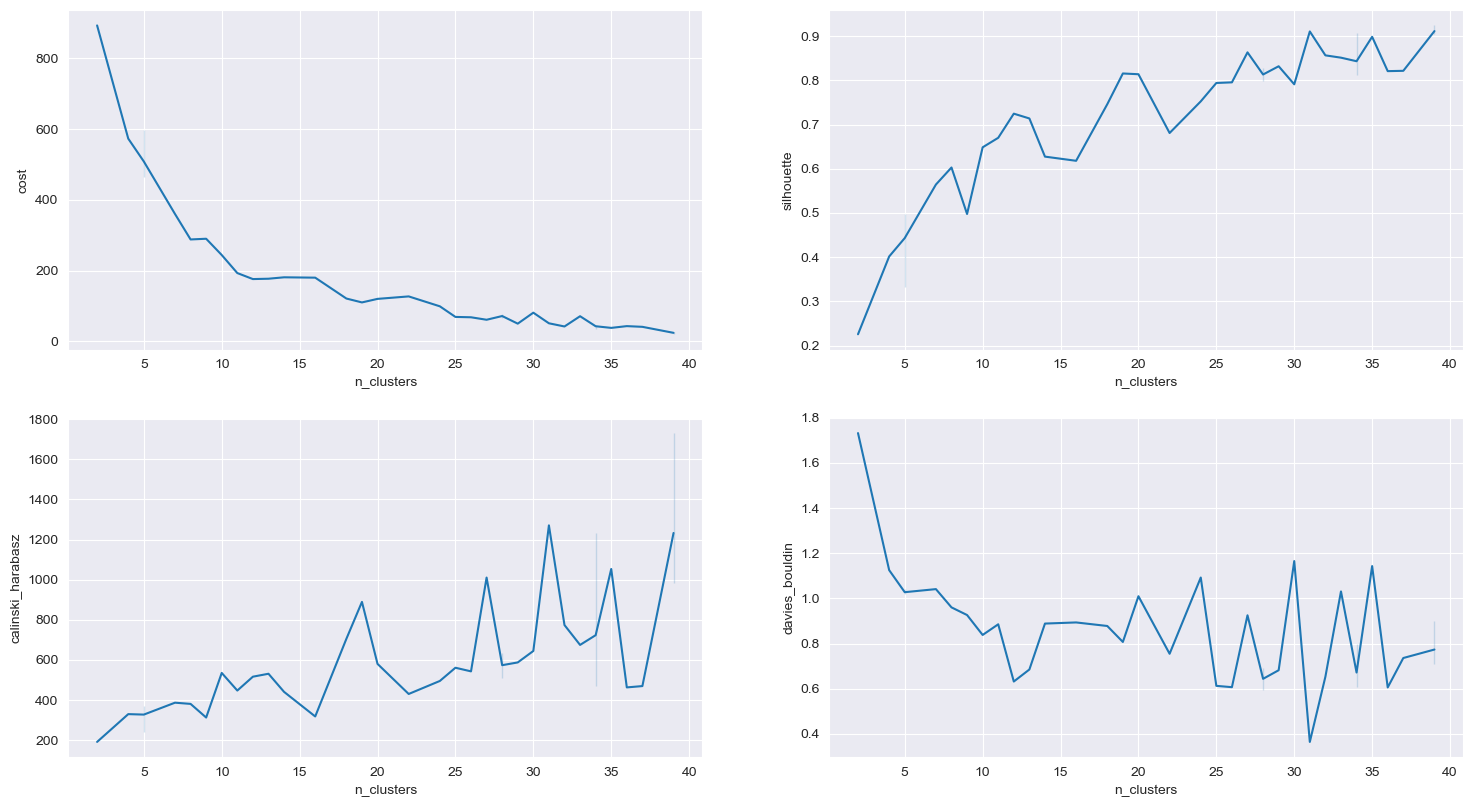

In [19]:
multiple_graphs(2, 'n_clusters', pd.DataFrame(trials.results).sort_values('loss').drop(['status', 'loss', 'init'], axis=1))

## Обучение K-prototypes

Алгоритм K-Prototypes — это гибрид K-Means (для числовых признаков) и K-Modes (для категориальных признаков). Он позволяет кластеризовать данные, содержащие оба типа признаков, находя оптимальные "прототипы" (центры кластеров), состоящие из средних значений для числовых признаков и мод (наиболее частых значений) для категориальных признаков.

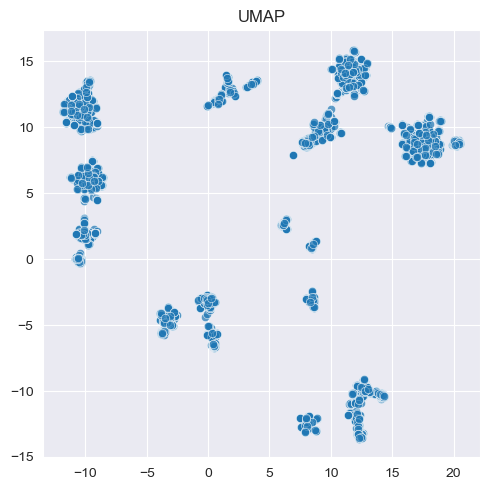

In [20]:
combined_cols = final_cat_cols.append(num_cols)
draw_clusters(df[combined_cols])

Видим вполне отчетливые кластеры.
Проведем оценку важности смешанных признаков с помощью класса PCA из библиотеки prince

In [21]:
pca = PCA(engine='sklearn')
pca.fit(df[num_cols])
loadings = pca.column_correlations
explained_var = pca.eigenvalues_
feature_importance = (np.abs(loadings).multiply(explained_var, axis=1)).sum(axis=1)
feature_importance = feature_importance.sort_values(ascending=False)
feature_importance

variable
positive         1.410567
negative         1.396803
views_count      1.123809
mean_progress    1.012418
dtype: float64

Удалим наименее важные признаки из числовых и категориальных

In [22]:
final_combined_cols = combined_cols.drop(feature_importance[-2:].index.to_list())
X = df[final_combined_cols].head(num_rows)
X.head()

,profile_is_child,genres,period,positive,negative
0,0,drama,Day,0.0,0.002918
1,0,horror,Day,0.0,0.002918
2,0,drama,Night,0.0,0.002918
3,0,drama,Morning,0.0,0.002918
4,0,comedy,Day,0.0,0.002918


Обучим k-prototypes из коробки

In [23]:
# k-prototypes требует указания категориальных признаков
cats = list(range(len(X.select_dtypes(include=['int64', 'object']).columns)))
k_proto = KPrototypes(n_jobs=-1)
clusters = k_proto.fit_predict(X, categorical=cats)
scores = scores_calc(X, clusters, metric="precomputed")
print(f"Silhouette Score: {scores[0]} \nCalinski-Harabasz Score: {scores[1]}\nDavies-Bouldin Score: {scores[2]}")

Silhouette Score: 0.535061240196228 
Calinski-Harabasz Score: 307.561085448987
Davies-Bouldin Score: 1.1295104455787124


Получили уже неплохой Silhouette Score.<br> Сделаем оптимизацию минимума кластеров с hyperopt. В качестве параметров оптимизации Есть еще gamma - весовой коэффициент, балансирующий влияние числовых и категориальных признаков. Но по умолчанию он расчитывается автоматически.

In [24]:
def objective_proto(params):
    n_clrs = int(params['n_clusters'])
    init = params['init']
    try:
        model = KPrototypes(n_clusters=n_clrs, init=init, random_state=42, n_jobs=-1)
        clrs = model.fit_predict(X, categorical=cats)
        cost = model.cost_
        penalty = 0.3 * n_clrs
        ss, chs, dbi = scores_calc(X, clrs, 'precomputed')
        return {
            'loss': -ss + cost + dbi - chs + penalty,
            'status': 'ok', 
            'n_clusters': n_clrs, 
            'cost': cost, 
            'silhouette': ss,
            'calinski_harabasz': chs,
            'davies_bouldin': dbi,
            'init': init
        }
    except Exception as e:
        print(e)
        return {'loss': float('inf'), 'status': 'fail'}
space = {
    'n_clusters': hp.choice('n_clusters', range(2, 35)),
    'init': hp.choice('init', ['Huang', 'Cao'])
}
trials = Trials()
fmin(fn=objective_proto, space=space, algo=tpe.suggest, max_evals=40, trials=trials)
print(f"Лучшие гиперпараметры:\n{trials.best_trial['result']}")
n_proto = trials.best_trial['result']['n_clusters']
i_proto = trials.best_trial['result']['init']

100%|██████████| 40/40 [00:50<00:00,  1.26s/trial, best loss: -1213.9491523230745]
Лучшие гиперпараметры:
{'loss': -1213.9491523230745, 'status': 'ok', 'n_clusters': 33, 'cost': 1.1453978854465308, 'silhouette': 0.9376315, 'calinski_harabasz': 1225.0035805382392, 'davies_bouldin': 0.9466618175645642, 'init': 'Huang'}


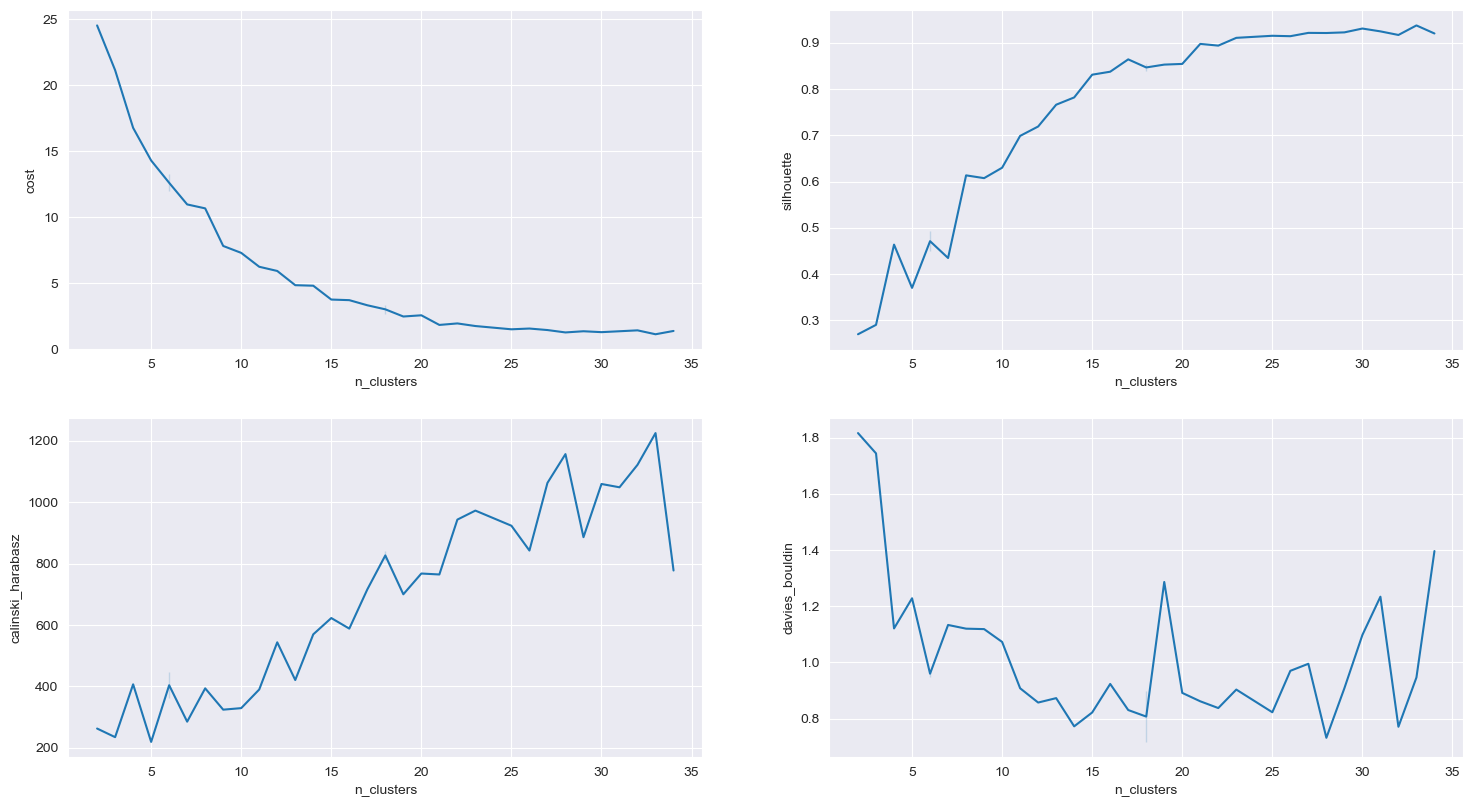

In [25]:
multiple_graphs(2, 'n_clusters', pd.DataFrame(trials.results).sort_values('loss').drop(['status', 'loss', 'init'], axis=1))

Оценим обе модели на всем датасете.

In [26]:
X_km = df[final_cat_cols]
km = KModes(n_clusters=n_kmodes, random_state=42, init=i_kmodes, n_jobs=-1)
km_clusters = km.fit_predict(X_km)
km_scores = scores_calc(X_km, km_clusters, 'hamming')
print(f"Silhouette Score: {km_scores[0]} \nCalinski-Harabasz Score: {km_scores[1]}\nDavies-Bouldin Score: {km_scores[2]}")

Silhouette Score: 0.9346749209866193 
Calinski-Harabasz Score: 14253.624614822415
Davies-Bouldin Score: 0.9937359788235941


In [27]:
X_kp = df[final_combined_cols]
k_proto = KPrototypes(n_jobs=-1, random_state=42, n_clusters=n_proto, init = i_proto)
kp_clusters = k_proto.fit_predict(X_kp, categorical=cats)
kp_scores = scores_calc(X_kp, kp_clusters, metric="precomputed")
print(f"Silhouette Score: {kp_scores[0]} \nCalinski-Harabasz Score: {kp_scores[1]}\nDavies-Bouldin Score: {kp_scores[2]}")

Silhouette Score: 0.9481381773948669 
Calinski-Harabasz Score: 17438.371283884902
Davies-Bouldin Score: 1.137903092271749


In [28]:
print(f'минимум кластеров k-modes: {n_kmodes},\nминимум кластеров k-prototypes: {n_proto}')

минимум кластеров k-modes: 39,
минимум кластеров k-prototypes: 33


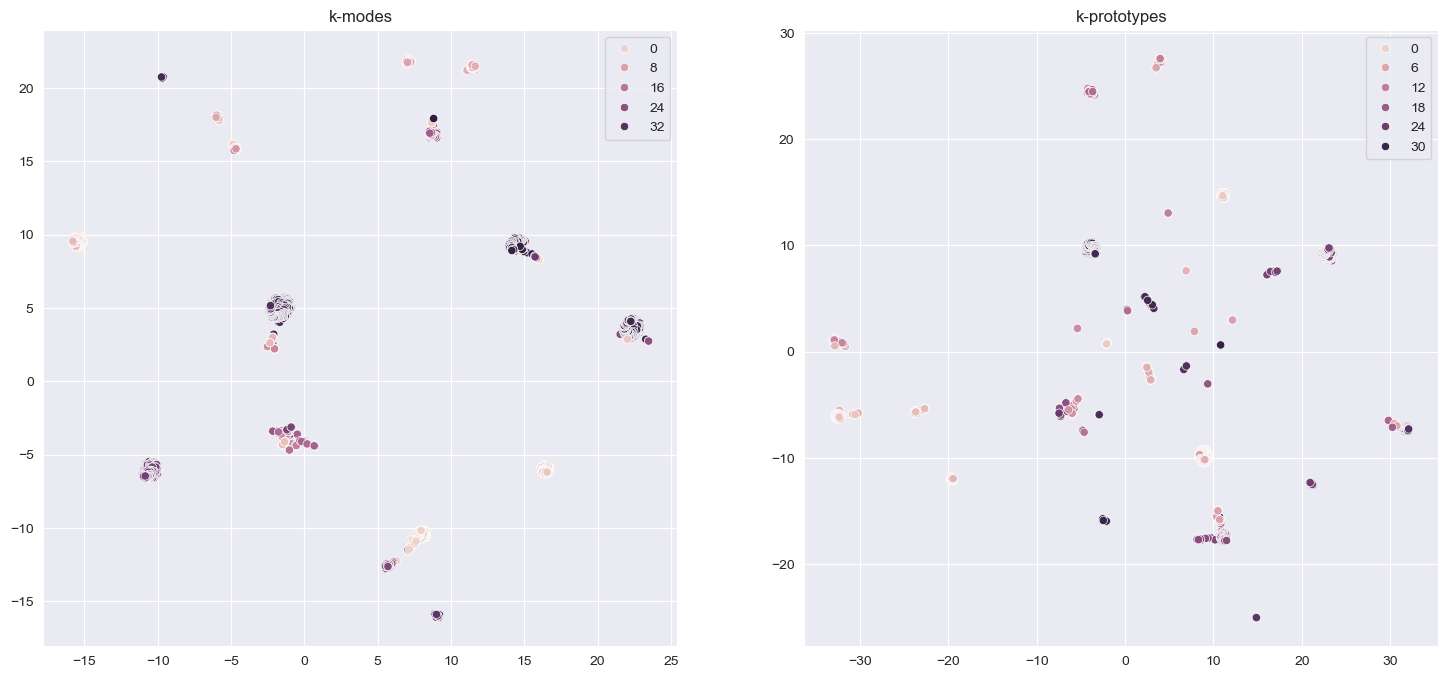

In [29]:
gm_kp = gower_matrix(X_kp)
emb_kp = umap.UMAP(metric='precomputed').fit_transform(gm_kp)
gm_km = gower_matrix(X_km)
emb_km = umap.UMAP(metric='precomputed').fit_transform(gm_km)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x=emb_km[:, 0], y=emb_km[:, 1], hue=km_clusters)
plt.title('k-modes')
plt.subplot(1, 2, 2)
sns.scatterplot(x=emb_kp[:, 0], y=emb_kp[:, 1], hue=kp_clusters)
plt.title('k-prototypes')
plt.show()

Видим сравнимые метрики. Davies-Bouldin у k-proto не намного хуже, но зато у k-proto меньшее количество кластеров и модель использует большее количество фичей, включая числовые.

## Сравнение с K-means и Bisecting K-Means
### K-means
K-Means - наиболее распространенный метод кластеризации, который разбивает данные на k кластеров. Цель алгоритма — минимизировать суммарное расстояние точек кластеров от их центров. Метод работает только с числовыми данными. Поэтому категориальные данные надо кодировать в числовые. <br> В качестве меры расстояния точек кластеров от их центров используется Евклидово расстояние. $$ d_(a,b) = \sqrt{\sum_{p = 1}^{P}(x_{i,p} - c_{j,p})^2 $$ где: <br> $x_i$ - объект, <br> $c_j$ - центроид кластера $j$, <br> $P$ - количество признаков <br>

Целевая функция (Within-Cluster Sum of Squares, WCSS): $$ J = \sum_{j=1}^k \sum_{x_j \in Cj} d(x_i, c_j)^2 $$

В отличие от предыдущих моделей, где инициализация осуществляется случайным образом, K-Means по умолчанию использует алгоритм инициализации K-Means++ - это то улучшенный метод выбора начальных центроидов, который позволяет избежать плохой кластеризации из-за неудачного случайного выбора.

Шаги алгоритма: <br>
1. По алгоритму K-Means++ выбираются $k$ точек из данных в качестве центроидов
2. Каждый объект назначается в ближайший кластер: $$ l_i = \arg \min_j (x_i, c_j)$$
3. Обновление центроидов. Новый центроид $c_j$ - среднее всех точек кластера $C_j$: $$ c_j = \frac{1}{|C_j|}\sum_{x_i \in C_j} x_i$$
4. Проверка сходимости. Если центроиды не изменились или достигнут максимум итераций → остановка, bначе → повтор шагов 2–3.

### Bisecting K-Means: Иерархическая версия K-Means <br>
Bisecting K-Means — это гибридный алгоритм кластеризации, сочетающий деление кластеров пополам (как в иерархической кластеризации) и K-Means. Он последовательно разбивает данные на всё меньшие кластеры, выбирая на каждом шаге самый "большой" кластер для разделения. <br>
Основные шаги алгоритма:
1. Инициализация: Начинаем с одного кластера, который включает все данные.
2. Итерация деления:
	- Выбираем кластер, который нужно разделить. Обычно это кластер с наибольшей внутриклассовой суммой квадратов (WCSS), что означает, что он менее компактный и имеет больше разброса.
	- Применяем K-Means для деления выбранного кластера на два подгруппы:
	- Запускаем K-means с $ k = 2 $ на данных этого кластера.
	- Таким образом, мы получаем две новые группы (подкластера).
3. Обновление: Обновляем список кластеров, добавляя новообразованные подкластеры к окончательным кластерным структурам.
4. Продолжение процесса: Повторяем шаг 2 до тех пор, пока не достигнем желаемого числа кластеров $ k $.

In [30]:
cat_features = final_cat_cols.tolist()
num_features = final_combined_cols.drop(cat_features).tolist()
X = df[final_combined_cols]

In [31]:
models = {
    'bisecting_kmeans': BisectingKMeans,
    'kmeans': KMeans
}
encoders = {
    'one_hot_encoder': ce.OneHotEncoder,
    'binary_encoder': ce.BinaryEncoder,
    'count_encoder': ce.CountEncoder
}
def objective_compare(params):
    n_clrs = int(params['n_clusters'])
    selected_model = models[params['model']]
    selected_encoder = encoders[params['encoder']]
    
    ct = ColumnTransformer([
        ('cat', selected_encoder(), cat_features)
    ], remainder='drop')
    pl = Pipeline(steps=[
        ('ct', ct),
        ('model', selected_model(n_clusters=n_clrs, random_state=42))
    ])
    pl.fit(X)    
    clrs = pl.predict(X)
    ss, chs, dbi = scores_calc(X, clrs, 'precomputed')
    penalty = 0.3 * n_clrs
    return {
            'loss': -ss + dbi - chs + penalty,
            'status': STATUS_OK,
            'n_clusters': n_clrs,
            'silhouette': ss,
            'calinski_harabasz': chs,
            'davies_bouldin': dbi,
            'clusters': clrs,
            'selected_model': selected_model,
            'selected_encoder': selected_encoder, 
            'best_pipeline': pl
        }
space = {
    'n_clusters': hp.choice('n_clusters', range(2, 35)),
    'model': hp.choice('model', list(models.keys())),
    'encoder': hp.choice('encoder', list(encoders.keys()))
}
trials = Trials()
best = fmin(fn=objective_compare, space=space, algo=tpe.suggest, max_evals=40, trials=trials)
print(trials.best_trial['result'])

100%|██████████| 40/40 [08:11<00:00, 12.29s/trial, best loss: -14452.061640675607]
{'loss': -14452.061640675607, 'status': 'ok', 'n_clusters': 21, 'silhouette': 0.934672, 'calinski_harabasz': 14458.071695113622, 'davies_bouldin': 0.6447264360401321, 'clusters': array([ 1,  1, 11, ...,  1,  3,  3], dtype=int32), 'selected_model': <class 'sklearn.cluster._kmeans.KMeans'>, 'selected_encoder': <class 'category_encoders.one_hot.OneHotEncoder'>, 'best_pipeline': Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['profile_is_child', 'genres',
                                                   'period'])])),
                ('model', KMeans(n_clusters=21, random_state=42))])}


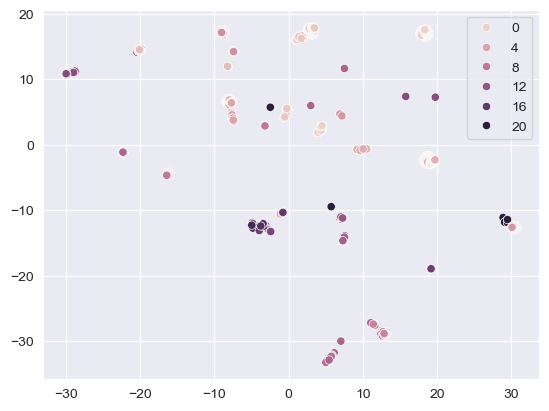

In [32]:
clusters = trials.best_trial['result']['clusters']
gm_means = gower_matrix(X)
emb = umap.UMAP(metric='precomputed').fit_transform(gm_means)
sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=clusters)
plt.show()

In [33]:
df['clusters'] = clusters

In [34]:
df.head()

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions,period,weekdays,views_count,mean_progress,clusters
0,de4599ae-01a2-46b5-8e23-49b47e0a1627,0,RU,"[608da742-46c3-4a5d-8134-532fd391a456, fb688a1...",tv,570663147,0.0,0.002918,drama,С субтитрами для слабослышащих,Series,"[2023-07-09 08:12:19, 2023-10-16 20:52:39, 202...","[0.116739236, 0.21479225, 0.8048347, 0.0646012...","[2023-07-09 08:56:19, 2023-10-16 22:03:39, 202...",Day,weekdays,0.033873,0.034902,1
1,bbbb3da4-f035-4eea-8f1f-30c954cc2ff9,0,RU,"[a3e1ac99-0641-4e28-906f-6b0e23835071, df54ef6...",mobile,28075000,0.0,0.002918,horror,Фильмы на Хэллоуин,Movie,"[2023-12-09 14:34:26, 2023-12-03 13:54:05, 202...","[0.86251444, 0.8919203, 0.69836575, 0.03018878]","[2023-12-09 14:36:26, 2023-12-03 13:58:02, 202...",Day,weekend,0.004418,0.026341,1
2,36183683-d0c0-4fcd-9890-4ef6cb6b2489,0,US,"[608da742-46c3-4a5d-8134-532fd391a456, 1987184...",web,424415879,0.0,0.002918,drama,С субтитрами для слабослышащих,Series,"[2023-07-19 05:14:22, 2023-10-22 05:53:51, 202...","[0.117806844, 0.12354234, 0.11813199, 0.258489...","[2023-07-19 05:14:22, 2023-10-22 06:40:25, 202...",Night,weekdays,0.086892,0.020469,11
3,630f1f10-381b-409f-bca3-489fe645999e,0,CA,"[49b1a1f6-a4bb-4a6c-adcc-fde2c0cbd0c4, 112116a...",tv,98034,0.0,0.002918,drama,various,Series,"[2023-09-14 08:17:20, 2023-07-29 04:48:00, 202...","[0.003368983, 0.00021035213, 9.444594e-06, 0.0...","[2023-09-14 08:17:21, 2023-07-29 04:48:21, 202...",Morning,weekdays,0.004418,0.000059,7
4,e48601ac-6ea1-4f82-b8fe-df6537fc3b21,0,GB,"[5de35919-f8a6-40e3-95a3-cbf90358d4c5, 7262fe6...",tv,6849535,0.0,0.002918,comedy,various,Series,"[2024-01-05 11:25:23, 2023-07-10 15:49:46, 202...","[0.124134436, 0.00097538676, 0.0010978448, 0.0...","[2024-01-05 11:25:23, 2023-07-10 18:46:43, 202...",Day,weekdays,0.004418,0.002065,4


In [35]:
df['titles'] = pd.read_csv('Result_13_5.csv')['titles']
df['titles'] = df['titles'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
df.head()

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions,period,weekdays,views_count,mean_progress,clusters,titles
0,de4599ae-01a2-46b5-8e23-49b47e0a1627,0,RU,"[608da742-46c3-4a5d-8134-532fd391a456, fb688a1...",tv,570663147,0.0,0.002918,drama,С субтитрами для слабослышащих,Series,"[2023-07-09 08:12:19, 2023-10-16 20:52:39, 202...","[0.116739236, 0.21479225, 0.8048347, 0.0646012...","[2023-07-09 08:56:19, 2023-10-16 22:03:39, 202...",Day,weekdays,0.033873,0.034902,1,"[Кошка, Контейнер, Преступление, Голиаф, Зёма,..."
1,bbbb3da4-f035-4eea-8f1f-30c954cc2ff9,0,RU,"[a3e1ac99-0641-4e28-906f-6b0e23835071, df54ef6...",mobile,28075000,0.0,0.002918,horror,Фильмы на Хэллоуин,Movie,"[2023-12-09 14:34:26, 2023-12-03 13:54:05, 202...","[0.86251444, 0.8919203, 0.69836575, 0.03018878]","[2023-12-09 14:36:26, 2023-12-03 13:58:02, 202...",Day,weekend,0.004418,0.026341,1,"[Клаустрофобы: Квест в Москве, Страшные истори..."
2,36183683-d0c0-4fcd-9890-4ef6cb6b2489,0,US,"[608da742-46c3-4a5d-8134-532fd391a456, 1987184...",web,424415879,0.0,0.002918,drama,С субтитрами для слабослышащих,Series,"[2023-07-19 05:14:22, 2023-10-22 05:53:51, 202...","[0.117806844, 0.12354234, 0.11813199, 0.258489...","[2023-07-19 05:14:22, 2023-10-22 06:40:25, 202...",Night,weekdays,0.086892,0.020469,11,"[Кошка, Однажды в Абхазии, Вася не в себе, Имп..."
3,630f1f10-381b-409f-bca3-489fe645999e,0,CA,"[49b1a1f6-a4bb-4a6c-adcc-fde2c0cbd0c4, 112116a...",tv,98034,0.0,0.002918,drama,various,Series,"[2023-09-14 08:17:20, 2023-07-29 04:48:00, 202...","[0.003368983, 0.00021035213, 9.444594e-06, 0.0...","[2023-09-14 08:17:21, 2023-07-29 04:48:21, 202...",Morning,weekdays,0.004418,0.000059,7,"[Вызов., Два холма, Жить жизнь, Престиж]"
4,e48601ac-6ea1-4f82-b8fe-df6537fc3b21,0,GB,"[5de35919-f8a6-40e3-95a3-cbf90358d4c5, 7262fe6...",tv,6849535,0.0,0.002918,comedy,various,Series,"[2024-01-05 11:25:23, 2023-07-10 15:49:46, 202...","[0.124134436, 0.00097538676, 0.0010978448, 0.0...","[2024-01-05 11:25:23, 2023-07-10 18:46:43, 202...",Day,weekdays,0.004418,0.002065,4,"[Инспектор Гаврилов, Сыщицы, Грозный папа, Бед..."


In [36]:
exploded_df = df.explode(['product_ids', 'progress', 'titles'])
exploded_df['progress'] = pd.to_numeric(exploded_df['progress'], errors='coerce')

def get_top_ids(exploded, threshold, nums=25, positive=True):
    progress = exploded_df['progress']
    filtered = exploded.where(progress > threshold) if positive else exploded.where(progress <= threshold)
    filtered = filtered.dropna()
    top = filtered.groupby(['clusters', 'product_ids', 'titles'], as_index=False).size()
    
    top = (top.groupby('clusters')
           .apply(lambda x: x.nlargest(nums, 'size'), include_groups=False)
           .reset_index()
           .drop(['level_1'], axis=1)
           )
    return top.groupby('clusters').aggregate(lambda x: [i for i in x])

positive_ids = (get_top_ids(exploded_df, 0.25).
                rename(columns={'product_ids': 'positive_ids', 'titles': 'positive_titles', 'size': 'positive_frequency'}))
negative_ids = (get_top_ids(exploded_df, 0.25, positive=False)
                .rename(columns={'product_ids': 'negative_ids','titles': 'negative_titles', 'size': 'negative_frequency'}))

ids = pd.concat([positive_ids, negative_ids], axis=1).reset_index(['clusters'])
ids.to_csv('positive_negative_ids.csv')

In [37]:
ids

,clusters,positive_ids,positive_titles,positive_frequency,negative_ids,negative_titles,negative_frequency
0,0.0,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 5de3591...","[Слово пацана. Кровь на асфальте, Инспектор Га...","[416, 363, 275, 246, 237, 229, 208, 185, 166, ...","[112116ae-3528-4d04-b056-4dd03a6c7fe6, 5de3591...","[Два холма, Инспектор Гаврилов, Против всех, С...","[448, 423, 369, 346, 293, 273, 239, 221, 214, ..."
1,1.0,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 75cb3e7...","[Слово пацана. Кровь на асфальте, Опасная близ...","[642, 220, 217, 211, 198, 196, 193, 184, 155, ...","[0bea8701-a413-4c6f-b748-877586219fcd, fb688a1...","[Жить жизнь, Контейнер, Два холма, Слово пацан...","[365, 279, 271, 266, 245, 226, 222, 214, 208, ..."
2,2.0,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 75cb3e7...","[Слово пацана. Кровь на асфальте, Опасная близ...","[68, 15, 10, 9, 9, 8, 8, 8, 7, 7, 6, 6, 6, 6, ...","[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 5de3591...","[Слово пацана. Кровь на асфальте, Инспектор Га...","[45, 39, 39, 35, 23, 22, 21, 19, 17, 16, 16, 1..."
3,3.0,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 75cb3e7...","[Слово пацана. Кровь на асфальте, Опасная близ...","[816, 277, 263, 241, 237, 225, 218, 199, 188, ...","[0bea8701-a413-4c6f-b748-877586219fcd, fb688a1...","[Жить жизнь, Контейнер, Два холма, Слово пацан...","[504, 362, 349, 308, 276, 275, 253, 253, 248, ..."
4,4.0,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 5de3591...","[Слово пацана. Кровь на асфальте, Инспектор Га...","[375, 317, 226, 213, 183, 178, 162, 152, 141, ...","[112116ae-3528-4d04-b056-4dd03a6c7fe6, 5de3591...","[Два холма, Инспектор Гаврилов, Против всех, С...","[393, 326, 311, 286, 238, 238, 178, 171, 168, ..."
5,5.0,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 5de3591...","[Слово пацана. Кровь на асфальте, Инспектор Га...","[105, 34, 34, 30, 29, 29, 26, 24, 24, 24, 23, ...","[0bea8701-a413-4c6f-b748-877586219fcd, 112116a...","[Жить жизнь, Два холма, Против всех, Последний...","[94, 85, 58, 58, 57, 55, 50, 48, 44, 42, 39, 3..."
6,6.0,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 5de3591...","[Слово пацана. Кровь на асфальте, Инспектор Га...","[71, 29, 28, 25, 24, 24, 21, 21, 21, 19, 19, 1...","[0bea8701-a413-4c6f-b748-877586219fcd, 112116a...","[Жить жизнь, Два холма, Против всех, Последний...","[66, 63, 47, 40, 39, 38, 37, 36, 34, 29, 28, 2..."
7,7.0,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 75cb3e7...","[Слово пацана. Кровь на асфальте, Опасная близ...","[228, 81, 62, 61, 56, 56, 55, 55, 51, 51, 50, ...","[0bea8701-a413-4c6f-b748-877586219fcd, b315e3c...","[Жить жизнь, Слово пацана. Кровь на асфальте, ...","[136, 126, 102, 93, 81, 76, 73, 71, 69, 69, 63..."
8,8.0,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 0bea870...","[Слово пацана. Кровь на асфальте, Жить жизнь, ...","[243, 47, 45, 39, 35, 31, 31, 29, 29, 25, 24, ...","[0bea8701-a413-4c6f-b748-877586219fcd, d979664...","[Жить жизнь, Черная весна, Слово пацана. Кровь...","[87, 83, 75, 60, 55, 43, 42, 41, 37, 36, 33, 3..."
9,9.0,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 5de3591...","[Слово пацана. Кровь на асфальте, Инспектор Га...","[105, 77, 63, 57, 54, 49, 45, 43, 42, 40, 39, ...","[112116ae-3528-4d04-b056-4dd03a6c7fe6, 999878e...","[Два холма, Против всех, Инспектор Гаврилов, С...","[112, 112, 92, 86, 70, 64, 56, 54, 49, 49, 46,..."
